# Classificação - Dados Abertos da PRF

## Carregando as bibliotecas

In [477]:
import textwrap

import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split


from matplotlib 		   import colormaps

## Carregando o dataset

In [478]:
datatran = pd.read_csv(
	"../dataset/prf/acidentes2024_todas_causas_tipos.csv",
	sep		 = ";",
	encoding = "latin1"
)

In [479]:
datatran.shape

(603215, 37)

## Preprocessamento do dataset

## Limpeza

In [480]:
datatran.columns

Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo', 'id_veiculo', 'tipo_veiculo', 'marca',
       'ano_fabricacao_veiculo', 'tipo_envolvido', 'estado_fisico', 'idade',
       'sexo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos',
       'latitude', 'longitude', 'regional', 'delegacia', 'uop'],
      dtype='object')

Descartanto características irrelevantes para a análise

In [481]:
irrelevantFeatures = [
	"id",
	"pesid",
	"data_inversa",
	"horario",
	"uf",
	"br",
	"km",
	"municipio",
	"sentido_via",
	"tracado_via",
	"id_veiculo",
	"marca",
	"ano_fabricacao_veiculo",
	"ilesos",
	"feridos_leves",
	"feridos_graves",
	"mortos",
	"latitude",
	"longitude",
	"regional",
	"delegacia",
	"uop",
	"dia_semana",
	"idade",
	"ordem_tipo_acidente",
    "causa_acidente"
]

In [482]:
datatran = datatran.drop(columns = irrelevantFeatures)

In [483]:
datatran.head()

,causa_principal,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_veiculo,tipo_envolvido,estado_fisico,sexo
0,Sim,Colisão com objeto,Com Vítimas Fatais,Plena Noite,Céu Claro,Dupla,Sim,Motocicleta,Condutor,Óbito,Masculino
1,Não,Colisão com objeto,Sem Vítimas,Plena Noite,Céu Claro,Dupla,Não,Automóvel,Condutor,Ileso,Feminino
2,Sim,Colisão com objeto,Sem Vítimas,Plena Noite,Céu Claro,Dupla,Não,Automóvel,Condutor,Ileso,Feminino
3,Sim,Colisão com objeto,Sem Vítimas,Plena Noite,Nublado,Múltipla,Sim,Caminhonete,Condutor,Ileso,Masculino
4,Não,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Chuva,Dupla,Não,Camioneta,Condutor,Ileso,Masculino


In [484]:
datatran.shape

(603215, 11)

Removendo linhas com valores vazios

In [485]:
datatran = datatran.dropna()

In [486]:
datatran.shape

(526000, 11)

Removendo linhas com sexo igual a Ignorado

In [487]:
datatran = datatran[
	(datatran['sexo'] != 'Não Informado') &
	(datatran['sexo'] != 'Ignorado')
]


In [488]:
datatran.shape

(500605, 11)

Atribuição compreensiva do 'uso_solo'

In [489]:
datatran['uso_solo'] = datatran['uso_solo'].str.replace("Sim", "Urbano")
datatran['uso_solo'] = datatran['uso_solo'].str.replace("Não", "Rural")

## Codificação das variáveis categóricas

Codificação da variável alvo

In [490]:
targetLabel = pd.DataFrame(index = datatran.index)

In [491]:
targetLabel['label'] = datatran['causa_principal']

targetLabel['label'] = targetLabel['label'].str.replace("Sim", "1")
targetLabel['label'] = targetLabel['label'].str.replace("Não", "0")

targetLabel['label'] = targetLabel['label'].astype(bool) 


In [492]:
targetLabel.shape

(500605, 1)

Aplicando One Hot Encoding

In [493]:
encoder = OneHotEncoder(sparse_output = False)

In [494]:
oneHotFeatures = encoder.fit_transform(
    X = datatran.drop(columns = ['causa_principal'])
)

oneHotFeatures.shape

(500605, 72)

In [495]:
oneHotFeatures = pd.DataFrame(
	data    = oneHotFeatures,
	columns = encoder.get_feature_names_out(),
	dtype   = bool
)

In [496]:
datatranEncoded = pd.concat(
    [targetLabel.reset_index(drop = True), oneHotFeatures.reset_index(drop = True)],
    axis = 1
)

In [497]:
datatranEncoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500605 entries, 0 to 500604
Data columns (total 73 columns):
 #   Column                                        Non-Null Count   Dtype
---  ------                                        --------------   -----
 0   label                                         500605 non-null  bool 
 1   tipo_acidente_Atropelamento de Animal         500605 non-null  bool 
 2   tipo_acidente_Atropelamento de Pedestre       500605 non-null  bool 
 3   tipo_acidente_Capotamento                     500605 non-null  bool 
 4   tipo_acidente_Colisão com objeto              500605 non-null  bool 
 5   tipo_acidente_Colisão frontal                 500605 non-null  bool 
 6   tipo_acidente_Colisão lateral mesmo sentido   500605 non-null  bool 
 7   tipo_acidente_Colisão lateral sentido oposto  500605 non-null  bool 
 8   tipo_acidente_Colisão transversal             500605 non-null  bool 
 9   tipo_acidente_Colisão traseira                500605 non-null  bool 
 

Normalização do dataset codificado

In [498]:
featuresEncoded = datatranEncoded.columns[
    ~datatranEncoded.columns.isin(values = ['label'])
]

In [499]:
scaler = StandardScaler()

datatranEncoded[featuresEncoded] = scaler.fit_transform(datatranEncoded[featuresEncoded])

## Analise Exploratória

Proporções dos valores categórios em cada coluna

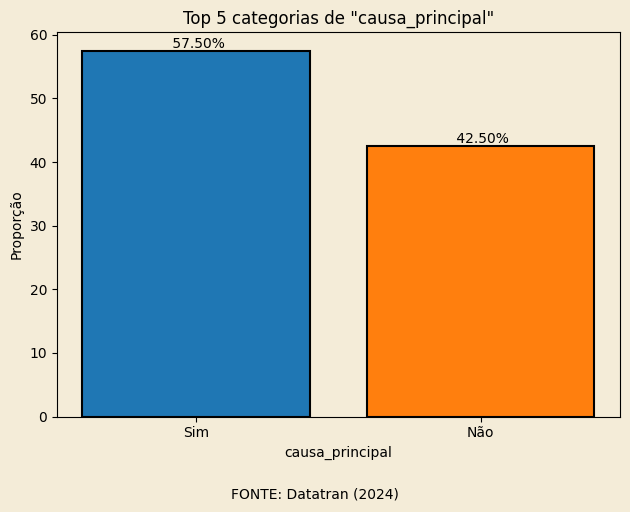

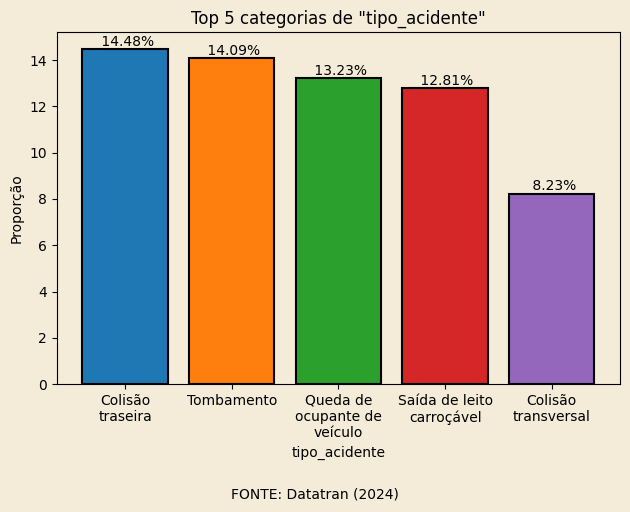

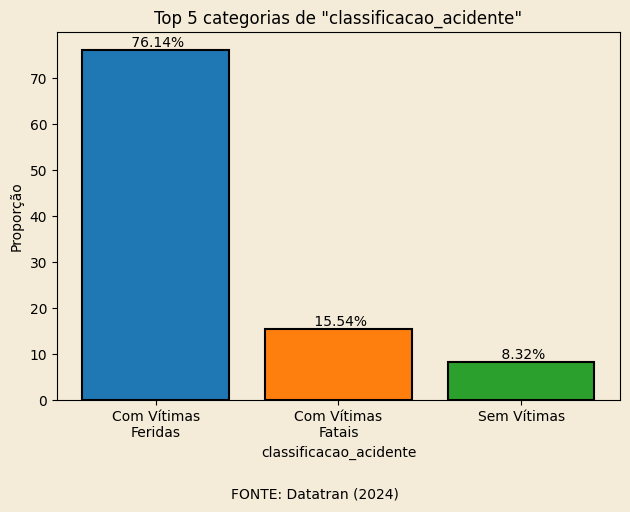

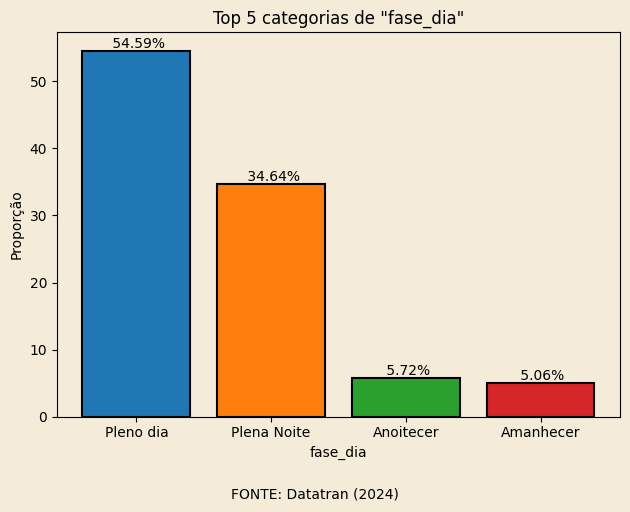

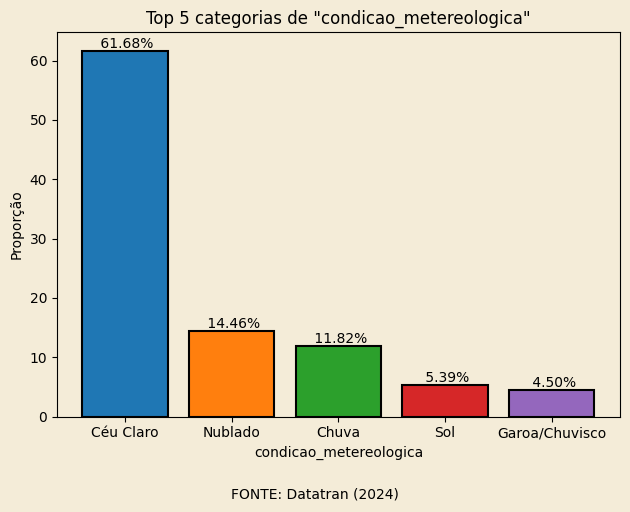

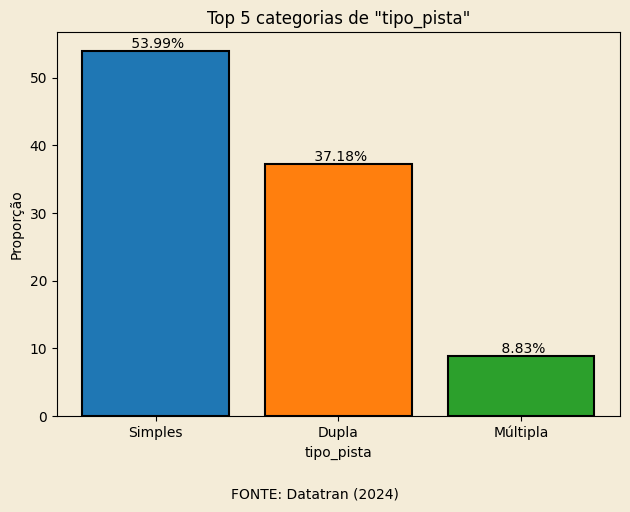

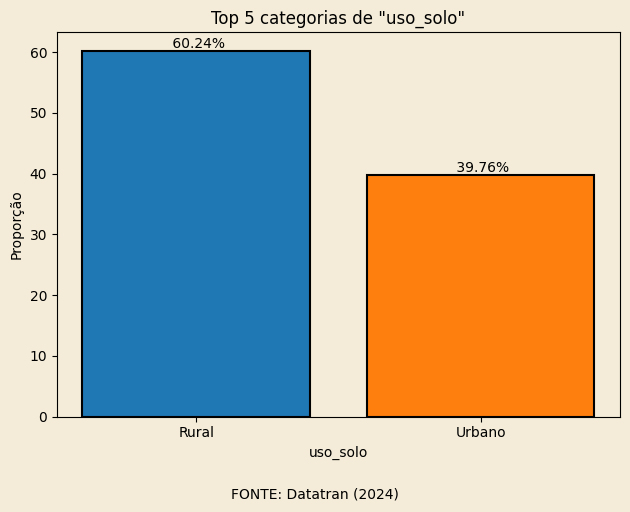

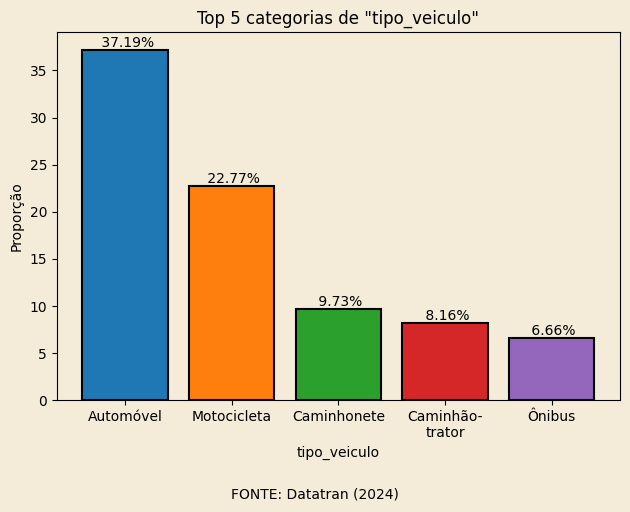

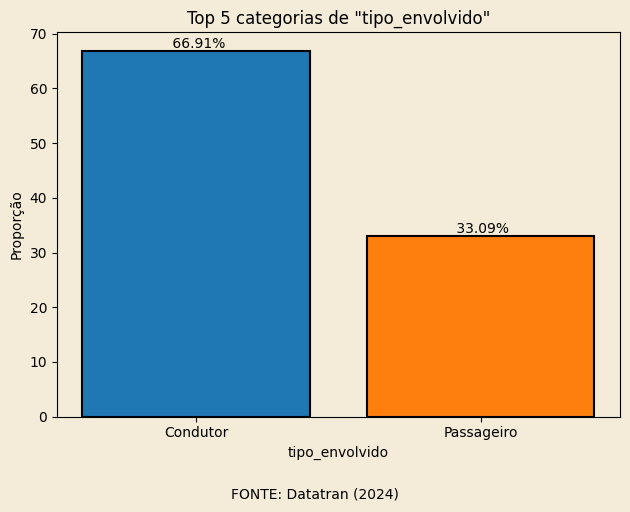

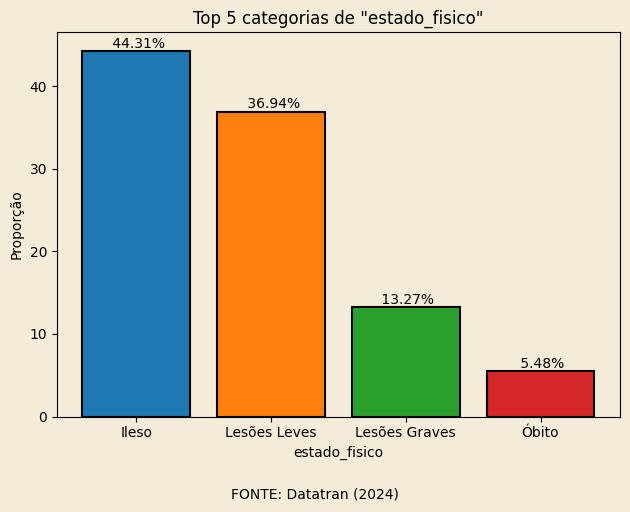

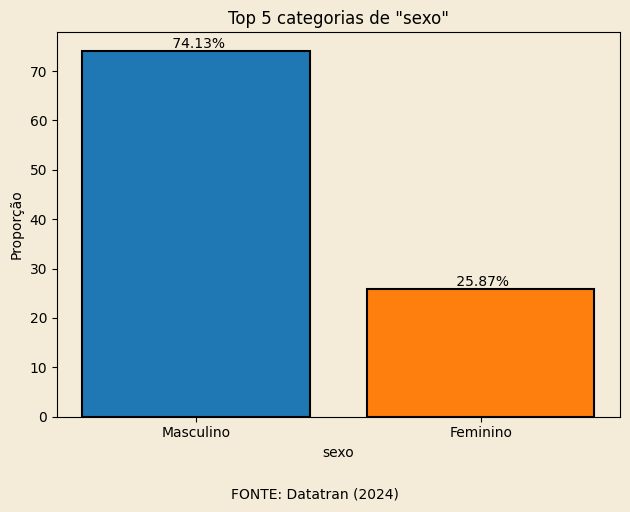

In [500]:
top = 5

for feature in datatran.columns:
	
	proportions = datatran[feature]\
		.value_counts(normalize = True, ascending = False)[:top]\
		.reset_index()
	
	proportions.columns = ['Categoria', 'Proporção']

	labels = [textwrap.fill(str(label), width = 14) for label in proportions['Categoria']]

	figure = plt.figure()


	plt.title(f'Top {top} categorias de "{feature}"')

	bars = plt.bar(
		x         = proportions['Categoria'],
		height    = proportions['Proporção'] * 100,
		color     = colormaps.get('tab10').colors,
		edgecolor = 'black',
		linewidth = 1.5

	)

	figure.set_facecolor("#F4ECD8")
	figure.axes[0].set_facecolor("#F4ECD8")

	for i, bar in enumerate(bars):

		height = bar.get_height()

		plt.text(
			i,                   
			height + 0.01,          
			f'{height: .2f}%', 
			ha       = 'center',    
			va       = 'bottom',    
			fontsize = 10
		)

	plt.xlabel(feature)
	plt.ylabel('Proporção')

	plt.xticks(
		ticks  = range(len(labels)), 
		labels = labels
	)

	plt.figtext(
		0.5, -0.05,                 
		'FONTE: Datatran (2024)',  
		horizontalalignment = 'center',
		fontsize            = 10
	)

	plt.tight_layout()

	plt.show()
	plt.close()

Proporções dos valores categórios em cada coluna dada a causa principal

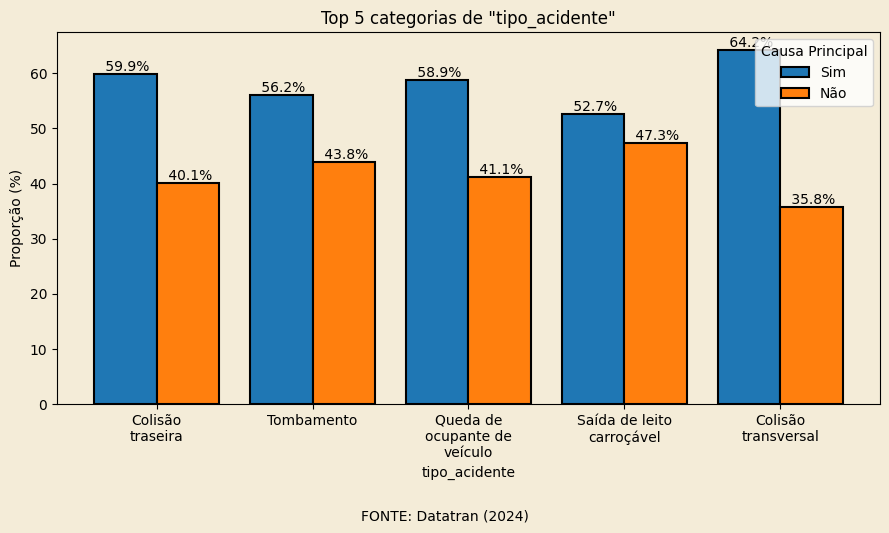

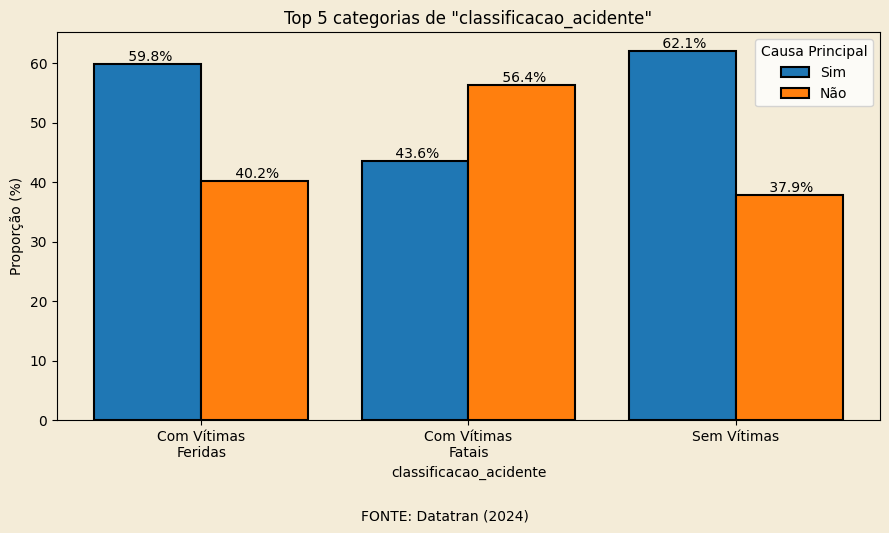

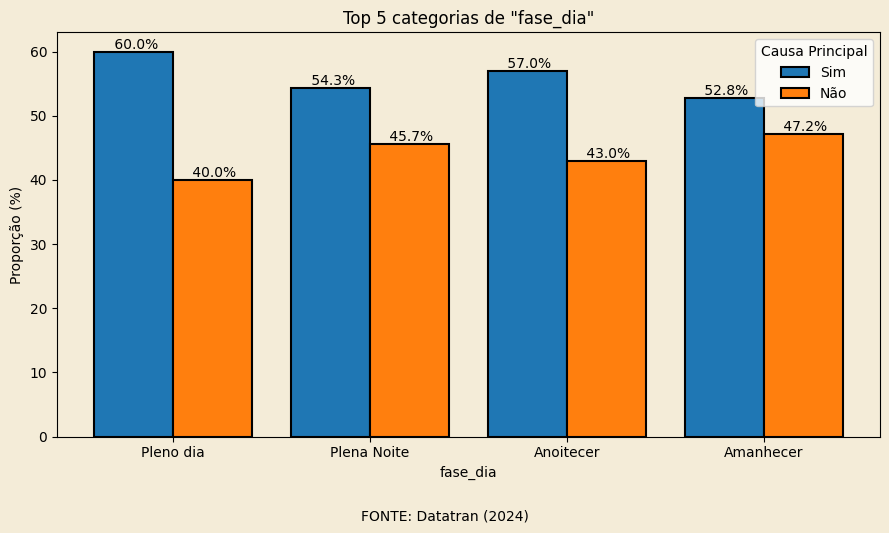

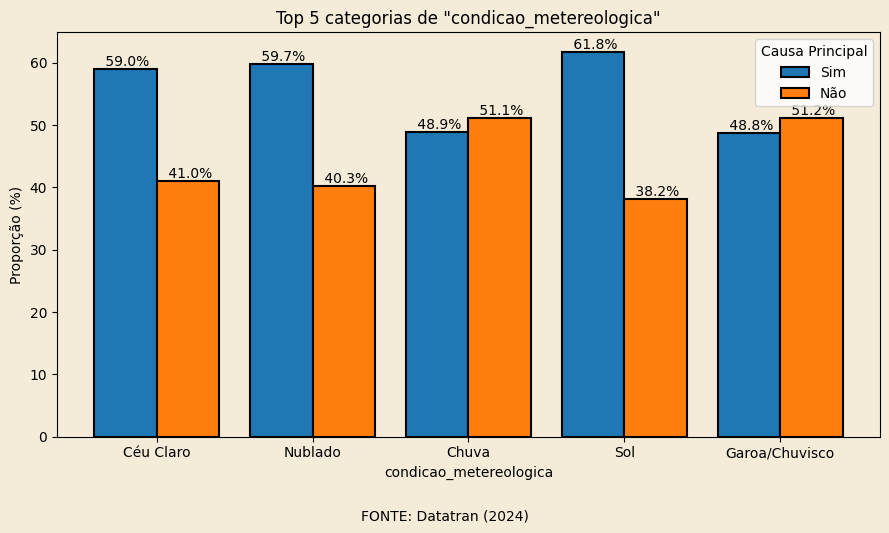

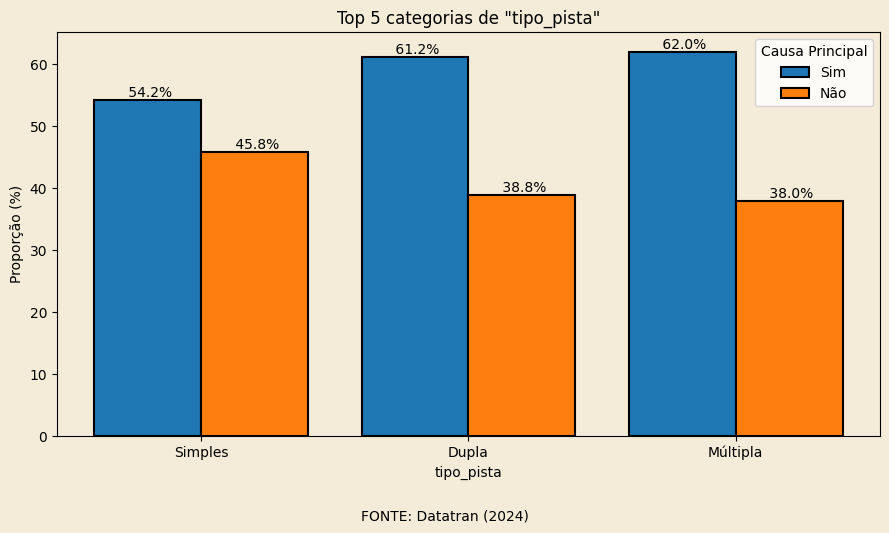

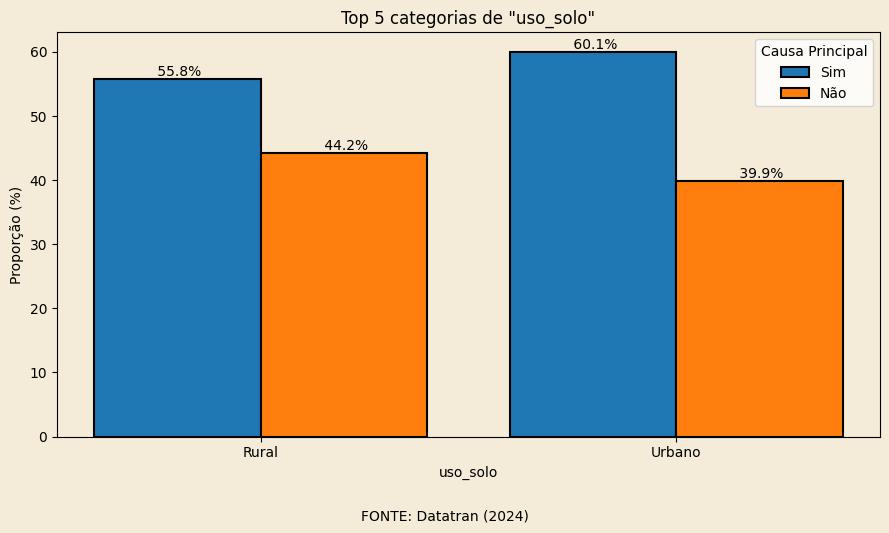

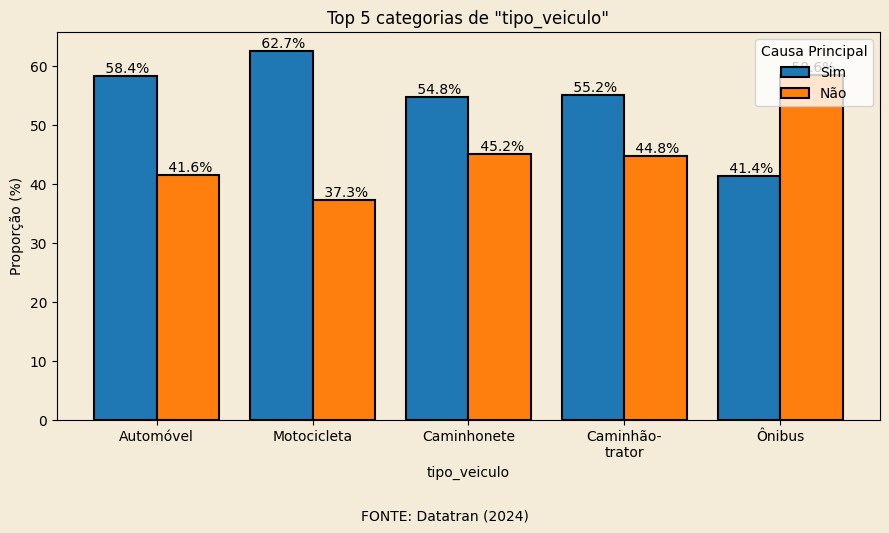

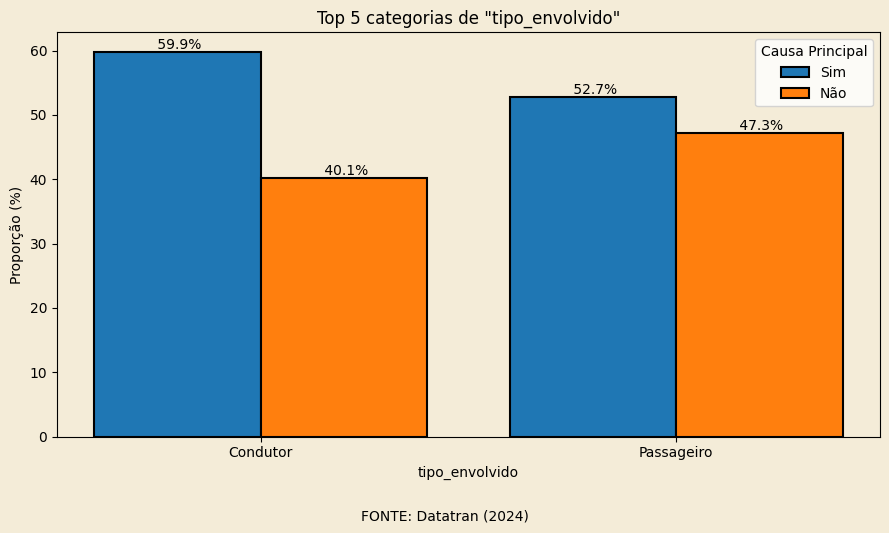

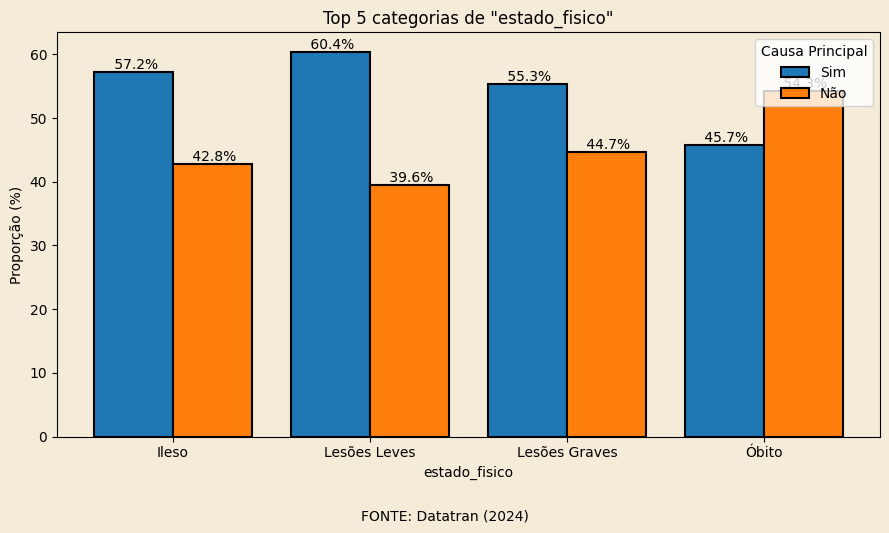

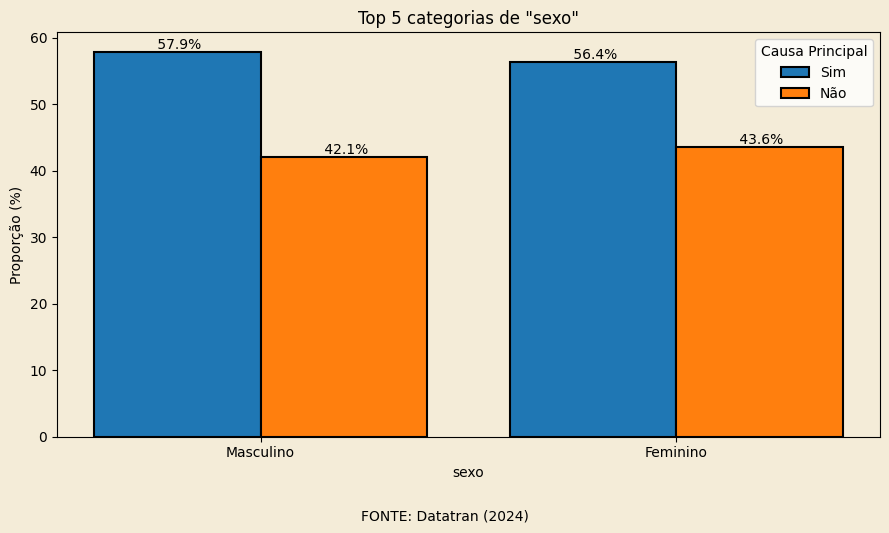

In [501]:
top = 5

for feature in datatran.columns:

	if feature == 'causa_principal':
		continue

	topCategories       = datatran[feature].value_counts(normalize=True)[:top].index
	topCategoriesFilter = datatran[datatran[feature].isin(topCategories)]

	count = (
		topCategoriesFilter
		.groupby([feature, 'causa_principal'])
		.size()
		.reset_index(name = 'Contagem')
	)

	count['Proporcao'] = (
		count
		.groupby(feature)['Contagem']
		.transform(lambda x: x / x.sum()) * 100
	)

	count[feature] = pd.Categorical(
		count[feature], 
		categories = topCategories, 
		ordered    = True
	)
	
	count  = count.sort_values(by = feature)
	labels = [textwrap.fill(str(label), width=14) for label in topCategories]

	figure, axes = plt.subplots(figsize = (9, 5))
	
	figure.set_facecolor("#F4ECD8")
	axes.set_facecolor("#F4ECD8")

	barWidth = 0.4
	x = range(len(topCategories))

	for i, value in enumerate(['Sim', 'Não']):
		
		groups    = count[count['causa_principal'] == value]
		ṕositions = [j + (i - 0.5) * barWidth for j in x]

		axes.bar(
			ṕositions,
			groups['Proporcao'],
			width     = barWidth,
			label     = value,
			color     = colormaps.get('tab10').colors[i],
			edgecolor = 'black',
			linewidth = 1.5
		)

		for xi, yi in zip(ṕositions, groups['Proporcao']):
			axes.text(
				xi, yi,
				f'{yi: .1f}%',
				ha       = 'center',
				va       = 'bottom',
				fontsize =  10
			)

	axes.set_title(f'Top {top} categorias de "{feature}"')
	
	axes.set_xlabel(feature)
	axes.set_ylabel('Proporção (%)')
	
	axes.set_xticks(x)
	axes.set_xticklabels(labels)
	
	axes.legend(title = 'Causa Principal')

	plt.figtext(
		0.5, -0.05,
		'FONTE: Datatran (2024)',
		horizontalalignment = 'center',
		fontsize            = 10
	)

	plt.tight_layout()
	plt.show()
	plt.close()


## Seleção dos atributos


Aplicando PCA

In [502]:
pcaVariance = .90
pca 		= PCA(n_components = pcaVariance)

In [503]:
datatranPCAData = pca.fit_transform(datatranEncoded[featuresEncoded])
featuresPCA     = [f'v{i}' for i in range(pca.n_components_)]

In [504]:
datatranPCA = pd.DataFrame(
    columns = featuresPCA,
    data    = datatranPCAData
)
datatranPCA['label'] = datatranEncoded['label']

In [505]:
print(f"{pca.n_components_} componentes para {pcaVariance: .2f} da variância") 

53 componentes para  0.90 da variância


## Hold out do dataset

In [506]:
X = datatranPCA[featuresPCA]
y = datatranPCA['label']

In [507]:
XTrain, XTest, yTrain, yTest = train_test_split(
    X,
    y,
    train_size   = .70,
    stratify     = y,
    random_state = 42
)

## Treinamento do modelo

1. Realize a validação cruzada usando o KFold com $k = 10$
1. Treine o modelo com todo o dataset de Treino

> Use os dados de **Treino**

## Teste do modelo

1. Teste o modelo

# Avaliação do modelo

1. Gere a curva ROC
1. Gere a tabela de confusão
1. Gere outros métricas que desejar